In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
     

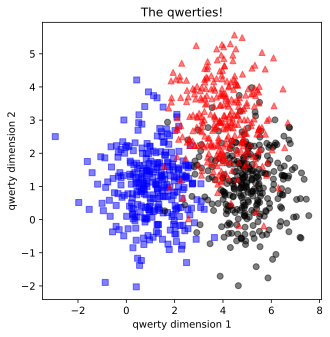

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

#true labels
labels_np=np.hstack((np.zeros((nPerClust)),
                     np.ones((nPerClust)),
                     1+np.ones((nPerClust))))

data_np=np.hstack((a,b,c)).T

data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).long()


fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()
     


In [3]:
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.1)

#now we convert  them into Pytorch datasets
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

batchsize=16
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
def createModel(optimizerAlgo,learningrate):
    class Model(nn.Module):
        def __init__(self):
            super().__init__()

            self.input=nn.Linear(2,8)
            self.fc1=nn.Linear(8,8)
            self.output=nn.Linear(8,3)

        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            return self.output(x)
    net=Model()
    lossfun=nn.CrossEntropyLoss()
    optifun=getattr(torch.optim,optimizerAlgo)
    #the above is the optimizer class
    optimizer=optifun(net.parameters(),lr=learningrate)
    #this is the optimizer instance
    
    

    return net,lossfun,optimizer

    

In [14]:
def function2trainTheModel(optimizerType,learningrate):
    numepochs=50
    net,lossfun,optimizer=createModel(optimizerType,learningrate)
    losses=torch.zeros(numepochs)

    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]

        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)

            #Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            #loss is a pytorch tensor, we cant just store the tensor with gradiets in a list as it is inefficient
            #.item converts the tensor to a float
            accuracyPct=(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
            batchAcc.append(accuracyPct)
            #end of the batch loop, now we get out of the loop and calculate accuracy for epoch
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivates autograd
         yHat = net(X)
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    return trainAcc,testAcc,losses,net


We are testing the effect of various various learning rates in the performance of the optimizer,
for this we need to take a learning rate and  perform "n" epochs for that specific optimizer type

In [18]:
learningRates=np.logspace(np.log10(.0001),np.log10(.1),20)
optimTypes=['SGD','RMSprop','Adam']

#then we initialize a performance matrix
finalPerformance=np.zeros((len(learningRates),len(optimTypes)))

#for experiment
for idx_o,opto in enumerate(optimTypes):
    for idx_l,lr in enumerate(learningRates):
        trainAcc,testAcc,losses,net=function2trainTheModel(opto,lr)
        finalPerformance[idx_l,idx_o]=np.mean(testAcc[-10:])
        


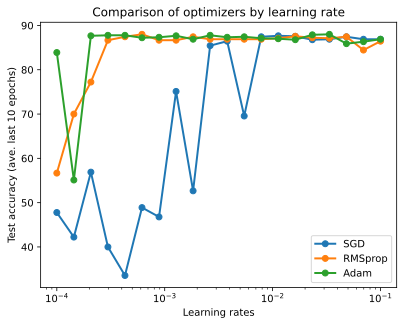

In [19]:
# plot the results!
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()